In [152]:
import pandas as pd

# df=pd.read_csv("df_final_2.csv")
X_train = pd.read_csv('child-mind-institute-problematic-internet-use/train.csv').iloc[:, :-1]
y_train = pd.read_csv('child-mind-institute-problematic-internet-use/train.csv').iloc[:, -1]
X_test = pd.read_csv('child-mind-institute-problematic-internet-use/test.csv').iloc[:, :-1]
y_test = pd.read_csv('child-mind-institute-problematic-internet-use/test.csv').iloc[:, -1]

# X_train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv').iloc[:, :-1]
# y_train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv').iloc[:, -1]
# X_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv').iloc[:, :-1]
# y_test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv').iloc[:, -1]

In [153]:
from sklearn.preprocessing import PolynomialFeatures

def get_aggregations(df, column_groupby, column_agg):

    if not isinstance(column_agg, list):
        column_agg = [column_agg]
    
    # Create the aggregation dictionary
    aggregation_dict = {}
    for col in column_agg:
        aggregation_dict.update({
            f'Median_{col}': (col, 'median'),
            f'Max_{col}': (col, 'max'),
            f'Min_{col}': (col, 'min'),
            f'Sum_{col}': (col, 'sum'),
            f'Std_{col}': (col, 'std'),
            f'Mean_{col}': (col, 'mean')
        })
    
    # Perform groupby and aggregation
    df_agg = df.groupby(column_groupby).agg(**aggregation_dict).reset_index()

    return df_agg

def get_polynomial_features(df, columns, degree=2):
    
    if not isinstance(columns, list):
        columns = [columns]
    # Initialize PolynomialFeatures with specified degree
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    # Select columns and generate polynomial features
    poly_features = df[columns]
    poly_array = poly.fit_transform(poly_features)
    
    # Get feature names and create DataFrame from polynomial array
    poly_feature_names = poly.get_feature_names_out(columns)
    poly_df = pd.DataFrame(poly_array, columns=poly_feature_names, index=df.index)
    
    # Concatenate the original DataFrame with polynomial features
    df_with_poly = pd.concat([df, poly_df], axis=1)

In [154]:
other_columns = []
column_groupby = 'PCIAT-PCIAT_Total'
column_agg=['FGC-FGC_CU','Physical-Systolic_BP','Physical-Diastolic_BP','Physical-BMI','BIA-BIA_BMC','BIA-BIA_BMI','Basic_Demos-Age','Basic_Demos-Sex']
# column_agg=['FGC-FGC_CU','Physical-Systolic_BP','Physical-Diastolic_BP','Physical-BMI'] # 0.152

df_agg = get_aggregations(X_train, column_groupby=column_groupby, column_agg=column_agg)

for column in df_agg.columns:
    df_agg[column] = df_agg[column].fillna(df_agg[column].mean())

In [155]:
# from sklearn.preprocessing import PolynomialFeatures

# # Verificar pra calcular separadamente ou tudo junto polinomios e relacoes se adicionar mais de uma coluna
# poly_df = get_polynomial_features(df_agg, columns=column_agg, degree=2)

# df_agg = pd.concat([df_agg, poly_df], axis=1)

In [156]:
print(f'Features with highest correlation to {column_groupby} \n')
columns_corr=[]
for column in column_agg:

    corr_df = df_agg.loc[:, df_agg.columns[df_agg.columns.str.endswith(column)].tolist()]
    corr_df[column_groupby] = df_agg[column_groupby]
    correlation_matrix = corr_df.corr()
    feature_highest_corr = correlation_matrix[column_groupby].drop(column_groupby).abs().idxmax()
    feature_corr_value = correlation_matrix[column_groupby].drop(column_groupby).abs().max()
    print(f'{feature_highest_corr}: {feature_corr_value} \n')

    columns_corr.append(feature_highest_corr)

print(columns_corr)

Features with highest correlation to PCIAT-PCIAT_Total 

Median_FGC-FGC_CU: 0.6644843180692392 

Min_Physical-Systolic_BP: 0.6429503351979634 

Min_Physical-Diastolic_BP: 0.6151229554265928 

Median_Physical-BMI: 0.65414920713236 

Median_BIA-BIA_BMC: 0.673042684902567 

Min_BIA-BIA_BMI: 0.6592806566970287 

Mean_Basic_Demos-Age: 0.910153146014278 

Sum_Basic_Demos-Sex: 0.6056946649630189 

['Median_FGC-FGC_CU', 'Min_Physical-Systolic_BP', 'Min_Physical-Diastolic_BP', 'Median_Physical-BMI', 'Median_BIA-BIA_BMC', 'Min_BIA-BIA_BMI', 'Mean_Basic_Demos-Age', 'Sum_Basic_Demos-Sex']


In [157]:
all_columns = other_columns + [column_groupby] + columns_corr

In [158]:
columns_df_agg = [column_groupby] + columns_corr
df_agg = df_agg.loc[:, columns_df_agg]

In [159]:
df_agg.describe()

,PCIAT-PCIAT_Total,Median_FGC-FGC_CU,Min_Physical-Systolic_BP,Min_Physical-Diastolic_BP,Median_Physical-BMI,Median_BIA-BIA_BMC,Min_BIA-BIA_BMI,Mean_Basic_Demos-Age,Sum_Basic_Demos-Sex
count,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000,93.000000
mean,46.075269,12.445055,94.763441,50.559140,19.788974,4.494338,15.568655,11.476051,10.720430
std,27.112983,6.410102,16.542040,10.927093,4.013770,1.103305,4.593786,1.988782,13.655995
min,0.000000,3.000000,49.000000,11.000000,15.515430,2.794585,0.048267,7.678571,0.000000
25%,23.000000,8.000000,87.000000,45.000000,17.570840,3.651295,13.487900,10.034483,3.000000
50%,46.000000,11.000000,93.000000,50.000000,18.618419,4.342710,14.225500,11.384615,9.000000
75%,69.000000,14.000000,101.000000,56.000000,19.933707,4.914095,16.238800,12.769231,16.000000
max,93.000000,35.000000,166.000000,87.000000,39.339185,8.182705,39.343500,17.000000,116.000000


In [160]:
# columns = [column_groupby]
# columns = columns + columns_corr + other_columns
# print(columns)
new_X_train = X_train.merge(df_agg, how='left', on=column_groupby)[all_columns]

In [161]:
for column in df_agg.columns:
    new_X_train[column] = new_X_train[column].fillna(df_agg[column].mean())

In [162]:
new_X_train.isna().sum()
len(new_X_train)

3960

In [163]:
new_df_train = new_X_train.select_dtypes(include='number')
correlation_matrix = new_df_train.corr()

In [164]:
correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)]

,PCIAT-PCIAT_Total,Median_FGC-FGC_CU,Min_Physical-Systolic_BP,Min_Physical-Diastolic_BP,Median_Physical-BMI,Median_BIA-BIA_BMC,Min_BIA-BIA_BMI,Mean_Basic_Demos-Age,Sum_Basic_Demos-Sex
PCIAT-PCIAT_Total,1.000000,0.798315,0.602366,0.533076,0.755443,0.760010,0.589979,0.923471,-0.629401
Median_FGC-FGC_CU,0.798315,1.000000,NaN,NaN,0.675867,0.747832,NaN,0.820947,-0.517403
Min_Physical-Systolic_BP,0.602366,NaN,1.000000,0.619203,0.516170,NaN,NaN,0.621598,-0.681920
Min_Physical-Diastolic_BP,0.533076,NaN,0.619203,1.000000,NaN,NaN,NaN,0.522276,-0.532994
Median_Physical-BMI,0.755443,0.675867,0.516170,NaN,1.000000,0.670244,0.619822,0.808789,NaN
Median_BIA-BIA_BMC,0.760010,0.747832,NaN,NaN,0.670244,1.000000,NaN,0.807725,-0.530578
Min_BIA-BIA_BMI,0.589979,NaN,NaN,NaN,0.619822,NaN,1.000000,0.511595,NaN
Mean_Basic_Demos-Age,0.923471,0.820947,0.621598,0.522276,0.808789,0.807725,0.511595,1.000000,-0.658748
Sum_Basic_Demos-Sex,-0.629401,-0.517403,-0.681920,-0.532994,NaN,-0.530578,NaN,-0.658748,1.000000


In [165]:
from sklearn.model_selection import train_test_split

df = pd.concat([new_X_train, y_train], axis=1)
df = df[df['sii'].notna()]
X = df.iloc[:, :-1]
y = df['sii']
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42)


In [166]:
import numpy as np
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train_split, y_train_split)
test_score = reg.score(X_test_split, y_test_split)
print(f'Test Score: {test_score}')

Test Score: 0.8630553403508546


In [167]:
null_indexes = y_train[y_train.isna()].index

In [168]:
X_null = new_X_train.iloc[null_indexes] 

In [169]:
y_pred = reg.predict(X_null) 

(array([   0.,    0.,    0.,    0.,    0., 1224.,    0.,    0.,    0.,
           0.]),
 array([0.74652269, 0.84652269, 0.94652269, 1.04652269, 1.14652269,
        1.24652269, 1.34652269, 1.44652269, 1.54652269, 1.64652269,
        1.74652269]),
 <BarContainer object of 10 artists>)

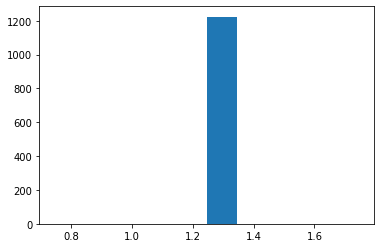

In [170]:
import matplotlib.pyplot as plt
plt.hist(y_pred)

In [171]:
y_train.iloc[null_indexes] = y_pred

In [172]:
y_train = np.round(y_train)

In [173]:
X_train = new_X_train.drop(columns=column_groupby)

In [174]:
local_X_train, local_X_test, local_y_train, local_y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [175]:
reg_2 = LinearRegression()
reg_2.fit(local_X_train, local_y_train)

LinearRegression()

In [176]:
X_train

,Median_FGC-FGC_CU,Min_Physical-Systolic_BP,Min_Physical-Diastolic_BP,Median_Physical-BMI,Median_BIA-BIA_BMC,Min_BIA-BIA_BMI,Mean_Basic_Demos-Age,Sum_Basic_Demos-Sex
0,10.500000,93.000000,55.00000,17.677979,4.255510,16.238800,12.588235,3.00000
1,5.000000,62.000000,34.00000,16.384381,3.107800,12.636700,7.881789,116.00000
2,10.000000,85.000000,39.00000,17.093043,3.765365,13.470000,10.187500,19.00000
3,14.000000,94.000000,44.00000,20.170728,4.714730,13.201600,11.805556,11.00000
4,12.445055,94.763441,50.55914,19.788974,4.494338,15.568655,11.476051,10.72043
...,...,...,...,...,...,...,...,...
3955,12.000000,97.000000,48.00000,17.631067,4.087070,11.434000,10.875000,14.00000
3956,12.445055,94.763441,50.55914,19.788974,4.494338,15.568655,11.476051,10.72043
3957,11.000000,98.000000,42.00000,19.406721,4.669360,12.654100,11.492308,28.00000
3958,10.000000,87.000000,53.00000,16.779041,3.195550,12.237200,9.511111,23.00000


In [177]:
reg_2.score(local_X_test, local_y_test)

0.7341970062570697

In [178]:
local_y_pred = reg_2.predict(local_X_test)

conditions = [local_y_pred <= 0, local_y_pred <= 1, local_y_pred <= 2, local_y_pred <= 3]
choices = [0, 1, 2, 3]
local_y_pred = np.select(conditions, choices, default=1)

In [ ]:
from sklearn.metrics import cohen_kappa_score

qwk_score_train = cohen_kappa_score(local_y_train, local_y_train, weights='quadratic')
qwk_score_val = cohen_kappa_score(local_y_test, local_y_pred, weights='quadratic')
print("Train QWK Score:", qwk_score_train)
print("Validation QWK Score:", qwk_score_val)


Train QWK Score: 1.0
Validation QWK Score: 0.5364580793054674


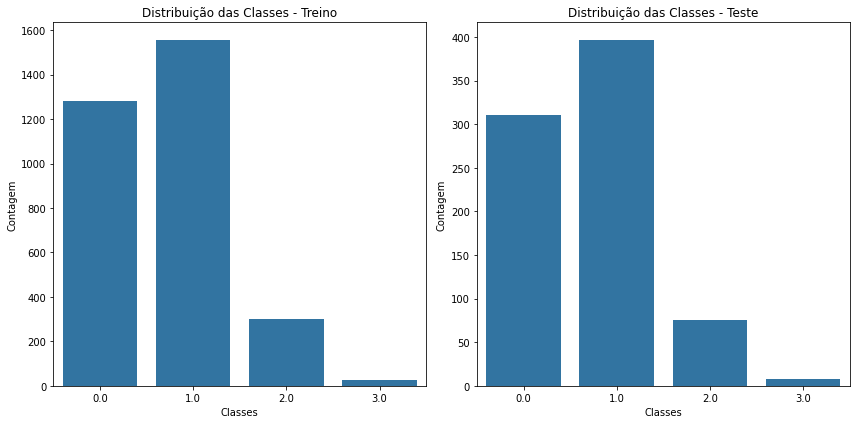

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suponha que você tenha um DataFrame `train` e `test`, e a coluna `target` contém a variável alvo
plt.figure(figsize=(12, 6))

# Treino
plt.subplot(1, 2, 1)
sns.countplot(x='sii', data=pd.DataFrame(local_y_train))
plt.title('Distribuição das Classes - Treino')
plt.xlabel('Classes')
plt.ylabel('Contagem')

# Teste
plt.subplot(1, 2, 2)
sns.countplot(x='sii', data=pd.DataFrame(local_y_test))
plt.title('Distribuição das Classes - Teste')
plt.xlabel('Classes')
plt.ylabel('Contagem')

plt.tight_layout()
plt.show()

In [181]:
# for column in columns_corr:
#     plt.figure(figsize=(12, 6))

#     # Treino
#     sns.kdeplot(local_X_train[column], label='Treino', color='blue')
#     sns.kdeplot(local_X_test[column], label='Teste', color='red')
#     plt.title(f'Distribuição {column} - Treino vs Teste')
#     plt.xlabel('Valores da Feature')
#     plt.ylabel('Densidade')
#     plt.legend()
#     plt.show()

In [182]:
all_columns

['PCIAT-PCIAT_Total',
 'Median_FGC-FGC_CU',
 'Min_Physical-Systolic_BP',
 'Min_Physical-Diastolic_BP',
 'Median_Physical-BMI',
 'Median_BIA-BIA_BMC',
 'Min_BIA-BIA_BMI',
 'Mean_Basic_Demos-Age',
 'Sum_Basic_Demos-Sex']

In [183]:
column_agg
# print(columns_agg_after)

['FGC-FGC_CU',
 'Physical-Systolic_BP',
 'Physical-Diastolic_BP',
 'Physical-BMI',
 'BIA-BIA_BMC',
 'BIA-BIA_BMI',
 'Basic_Demos-Age',
 'Basic_Demos-Sex']

In [184]:
X_test_predict = X_test.loc[:, column_agg + other_columns]

In [185]:
for column in column_agg:
    index = column_agg.index(column)
    X_test_predict[columns_corr[index]] = X_test_predict[column].fillna(df_agg[columns_corr[index]].mean())

In [186]:
X_test_predict = X_test_predict.loc[:, other_columns + columns_corr]
y_test = reg_2.predict(X_test_predict)

In [187]:
y_test

array([-1.50738969,  0.05193812,  0.6298559 ,  0.41245808,  3.60752293,
        2.25317699,  0.76507231,  0.40054859,  2.42337841,  4.00064517,
        0.85566724,  0.85088945,  2.35448387,  1.1935793 ,  1.24401169,
       -0.84180712, -1.64686409,  0.3608889 , -0.93656394,  0.45776721])

In [188]:
conditions = [y_test <= 0, y_test <= 1, y_test <= 2, y_test <= 3]
choices = [0, 1, 2, 3]

In [189]:
y_test_round = np.select(conditions, choices, default=1)

In [190]:
df_y_test = pd.DataFrame({'id': X_test['id'], 'sii': y_test_round})

In [191]:
from datetime import datetime
df_y_test.to_csv(f'submission.csv', index=False)

In [192]:
df_y_test

,id,sii
0,00008ff9,0
1,000fd460,1
2,00105258,1
3,00115b9f,1
4,0016bb22,1
5,001f3379,3
6,0038ba98,1
7,0068a485,1
8,0069fbed,3
9,0083e397,1
